<font color = blue size=5>Import Module</font>

In [1]:
#import the necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import jaconv
import re
import pickle as pkl
import warnings
import statsmodels.api as sm
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# To ignore the wanrings. Got many warnings from the data type
warnings.filterwarnings("ignore")
plt.rcParams['font.family'] = 'MS Gothic'

NUMBER_OF_DATA = 50000

<font color = blue size=5>Data Preparation</font>

In [2]:
# Import data from csv file
house_price_test = pd.read_csv("D:\\code\\school\\データサイエンス超入門\\通常課題１\\data\\utf\\13_Tokyo_20231_20231.csv")
house_price_history_data = pd.read_csv("D:\\code\\school\\データサイエンス超入門\\通常課題１\\data\\utf\\13_Tokyo_20053_20224.csv")

# house_price_history_data = pd.read_csv("school\\データサイエンス超入門\\通常課題１\\data\\utf\\SuperD_Class2_tochi_sample_xdm.csv")
house_price_alltime = house_price_history_data
house_price_recent50000 = house_price_history_data[house_price_history_data["取引時点"] == '2022年第４四半期']
code_reference = pd.read_csv("D:\\code\\school\\データサイエンス超入門\\通常課題１\\data\\utf\\SuperD_Class2_shicyoukuson_code_utf8.csv")

# get the most recent 50000 data
if len(house_price_recent50000) > NUMBER_OF_DATA:
    house_price_recent50000 = house_price_recent50000.sample(n = NUMBER_OF_DATA, random_state = 42)
else:
    house_price_history_data.sort_values(by = '取引時点', ascending= False, inplace = True)
    house_price_recent50000 = house_price_history_data.iloc[0:NUMBER_OF_DATA,:]
    
# get random 50000 data
house_price_random50000 = house_price_history_data.sample(n = NUMBER_OF_DATA, random_state= 42)     

<font color = blue size=5>Define Data Transformation Methods</font>

In [3]:
########################## Define Log Price Function ##########################
def log_price(df):
    df["log_price"] = np.log(df["取引価格（総額）"])
    return df


########################## Define Date Convert Function ##########################
transaction_date2date = {}
time = pd.DataFrame(house_price_alltime["取引時点"].value_counts())
quarterly_dict = {'１': 1, '２': 4, '３': 7, '４': 10}
transaction_date2date = {}
for i in range(len(time)):
    # the original str
    transaction_date = time.index[i]
    # year
    year_num = time.index[i][0:4]
    # quarterly to month
    month_num = quarterly_dict[jaconv.h2z(time.index[i][6])]
    # transform to datetime format
    date = datetime.datetime.strptime(str(year_num) + str(month_num), "%Y%m")
    transaction_date2date.update({transaction_date: date})

def date_convert(df):
    df["date"] = df["取引時点"].map(transaction_date2date)
    return df

########################## Define Area Convert Function ##########################
def area_convert(df):
    df_area = pd.DataFrame(df["面積（㎡）"].value_counts())
    square_meters2area = {}
    for i in range(len(df_area)):
        square_meters = df_area.index[i]
        area = re.sub("㎡以上", "", square_meters)
        area = re.sub("m&sup2;以上", "", area)
        area = re.sub(",", "", area)
        area = int(area)
        square_meters2area.update({square_meters: area})
    df["area"] = df["面積（㎡）"].map(square_meters2area)
    return df

########################## Define Location Convert Function ##########################
code2lng, code2lat = ({} for _ in range(2))
for i in range(len(code_reference)):
    code = str(code_reference["コード"].iloc[i])
    if (len(code) == 5):
        code = code[0:4]
    else:
        code = code[0:5]
    code2lng.update({int(code): code_reference["経度"].iloc[i]})
    code2lat.update({int(code): code_reference["緯度"].iloc[i]})

def location_convert(df):
    df["longitude"] = df["市区町村コード"].map(code2lng)
    df["latitude"] = df["市区町村コード"].map(code2lat)
    return df

########################## Define Type Dummy Function ##########################
def type_convert(df):
    df = pd.get_dummies(df, columns=["種類"])
    return df

########################## Define Circumstances Dummy Function ##########################
def cirum_convert(df):
    df = pd.get_dummies(df, columns=['取引の事情等'])
    return df

########################## Define Total Convert Function ##########################
def total_convert(df):
    df = cirum_convert(type_convert(area_convert(log_price(location_convert(date_convert(df))))))
    return df

<font color = blue size=5>Define Features and Label Dataframe Creating Function</font>

In [4]:
########################## Define Features and Label Dataframe Creating Function ##########################
def create_feature_and_label_dataframe(df):
    df_feature = df[[
    "area", "longitude", "latitude", '種類_中古マンション等',
    '種類_宅地(土地)', '種類_宅地(土地と建物)', '種類_林地', '種類_農地',
    '取引の事情等_その他事情有り',
    '取引の事情等_瑕疵有りの可能性',
    '取引の事情等_私道を含む取引', '取引の事情等_調停・競売等', '取引の事情等_調停・競売等、私道を含む取引',
    '取引の事情等_関係者間取引', '取引の事情等_関係者間取引、私道を含む取引', '取引の事情等_隣地の購入',
    '取引の事情等_隣地の購入、私道を含む取引'
    ]]
    # Target
    df_label = df[["log_price"]]
    return df_feature, df_label

########################## Define Extract and Load Function ##########################
def etl(df_feature, df_label):
    # write to csv
    df_feature.to_csv("land_price_x.csv", index=False)
    df_label.to_csv("land_price_y.csv", index=False)
    # save as pickle
    with open('df_x.pickle', 'wb') as f:
        pkl.dump(df_feature, f)
    with open('df_y.pickle', 'wb') as f:
        pkl.dump(df_label, f)
    # load pickle
    with open('df_x.pickle', 'rb') as f:
        df_feature = pkl.load(f)
    with open('df_y.pickle', 'rb') as f:
        df_label = pkl.load(f)
    return df_feature.values, df_label.values

<font color = blue size=5>Transforming and Creating Features and Label Dataframes</font>

In [5]:
########################## Traning Datasets Manipulation ##########################
## Transforming two training sets
house_price_recent50000 = total_convert(house_price_recent50000)
house_price_random50000 = total_convert(house_price_random50000)

## Creating Features and Label Dataframe Creating Function
recent50000_feature_df, recent50000_label = create_feature_and_label_dataframe(house_price_recent50000)
random50000_feature_df, random50000_label = create_feature_and_label_dataframe(house_price_random50000)

## Extract and Load
recent50000_feature, recent50000_label = etl(recent50000_feature_df, recent50000_label)
random50000_feature, random50000_label = etl(random50000_feature_df, random50000_label)

########################## Test Datasets Manipulation ##########################
## Transforming two training sets
house_price_test = total_convert(house_price_test)

## Creating Features and Label Dataframe Creating Function
test_feature, test_label = create_feature_and_label_dataframe(house_price_test)

## Extract and Load
test_feature, test_label = etl(test_feature, test_label)

## Datatype Adjustment Before
recent50000_feature_df.head(10)

,area,longitude,latitude,種類_中古マンション等,種類_宅地(土地),種類_宅地(土地と建物),種類_林地,種類_農地,取引の事情等_その他事情有り,取引の事情等_瑕疵有りの可能性,取引の事情等_私道を含む取引,取引の事情等_調停・競売等,取引の事情等_調停・競売等、私道を含む取引,取引の事情等_関係者間取引,取引の事情等_関係者間取引、私道を含む取引,取引の事情等_隣地の購入,取引の事情等_隣地の購入、私道を含む取引
0,15,139.753595,35.694003,True,False,False,False,False,False,False,False,False,False,False,False,False,False
6179,30,139.751599,35.658068,True,False,False,False,False,False,False,False,False,False,False,False,False,False
81982,120,139.653247,35.646572,False,False,True,False,False,False,False,False,False,False,False,False,False,False
81984,190,139.653247,35.646572,False,True,False,False,False,False,False,False,False,False,False,False,False,False
81986,30,139.653247,35.646572,True,False,False,False,False,False,False,False,False,False,False,False,False,False
81988,30,139.653247,35.646572,True,False,False,False,False,False,False,False,False,False,False,False,False,False
81990,30,139.653247,35.646572,True,False,False,False,False,False,False,False,False,False,False,False,False,False
81992,30,139.653247,35.646572,True,False,False,False,False,False,False,False,False,False,False,False,False,False
81994,30,139.653247,35.646572,True,False,False,False,False,False,False,False,False,False,False,False,False,False
36522,45,139.730186,35.609226,True,False,False,False,False,False,False,False,False,False,False,False,False,False


<font color = blue size=5>Datatype Adjustment</font>

In [6]:
########################## Datatype Adjustment (Important) ##########################
## Datatype adjustment in case the normalize function could not transfer the Boolean data(Dummy feature values)
recent50000_feature = recent50000_feature_df.astype(float)
recent50000_label = recent50000_label.astype(float)
random50000_feature = random50000_feature_df.astype(float)
random50000_label = random50000_label.astype(float)

test_feature = test_feature.astype(float)
test_label = test_label.astype(float)

## Datatype Adjustment After
recent50000_feature.head(10)

,area,longitude,latitude,種類_中古マンション等,種類_宅地(土地),種類_宅地(土地と建物),種類_林地,種類_農地,取引の事情等_その他事情有り,取引の事情等_瑕疵有りの可能性,取引の事情等_私道を含む取引,取引の事情等_調停・競売等,取引の事情等_調停・競売等、私道を含む取引,取引の事情等_関係者間取引,取引の事情等_関係者間取引、私道を含む取引,取引の事情等_隣地の購入,取引の事情等_隣地の購入、私道を含む取引
0,15.0,139.753595,35.694003,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6179,30.0,139.751599,35.658068,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81982,120.0,139.653247,35.646572,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81984,190.0,139.653247,35.646572,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81986,30.0,139.653247,35.646572,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81988,30.0,139.653247,35.646572,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81990,30.0,139.653247,35.646572,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81992,30.0,139.653247,35.646572,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81994,30.0,139.653247,35.646572,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36522,45.0,139.730186,35.609226,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<font color = blue size=8>Machine Learning</font>

<font color = blue size=5>Define Machine learning Common Function</font>

In [7]:
########################## Data Normalization Function ##########################
def data_normalize(data_array):
    return normalize(data_array, norm='l1')

########################## R-squared Score and MSE Score Calculation Function ##########################
def show_Rsquare_and_mse(y_test, y_test_predict):
    mse = mean_squared_error(y_test, y_test_predict)
    r2 = r2_score(y_test, y_test_predict)
    print(f'R-squared: {r2}')
    print(f'Mean Squared Error: {mse}')

########################## Accuracy Figure Demonstration Function ##########################
def show_predict_accuracy_figure(y_test, y_test_predict, title):
    x = np.linspace(15, 23, 100)
    y = x  
    plt.figure(figsize=(6,6))
    plt.plot(y_test_predict,y_test,marker="o",linestyle="",alpha=0.6,color="black")
    plt.plot(x, y, color = 'red', linestyle = '-')
    plt.title(title,size=16)
    plt.xlabel("prediction",size=16)
    plt.ylabel("true",size=16)

<font color = blue size=5> Define Sklearn Linear Regression Function</font>

In [8]:
########################## Linear Regression powered by sklearn ##########################
def sklearn_linear_learning(x_train, x_test, y_train, y_test, df):
    y_train = np.reshape(y_train, [-1])
    y_test  = np.reshape(y_test, [-1])
    model = LinearRegression()
    model.fit(data_normalize(x_train), y_train)
    # y_train_predict = model.predict(x_train)
    y_test_predict = model.predict(data_normalize(x_test))
    print("\nTraining result powered by Sklearn")
    show_Rsquare_and_mse(y_test, y_test_predict)
    coefficients = model.coef_
    for feature, coef in zip(df.columns, coefficients):
        print(f"{feature}: {coef}")
    return y_test, y_test_predict

In [9]:
print("\n\n########## Linear regression result on recent 50000 data powered by Sklearn ##########")
lr_y_test_recent, lr_y_test_predict_recent = sklearn_linear_learning(recent50000_feature, 
                                                                test_feature,
                                                                recent50000_label,
                                                                test_label, 
                                                                random50000_feature_df)
print("\n\n########## Linear regression result on random 50000 data powered by Sklearn ##########")
lr_y_test_random, lr_y_test_predict_random = sklearn_linear_learning(random50000_feature, 
                                                                test_feature,
                                                                random50000_label,
                                                                test_label, 
                                                                random50000_feature_df)



########## Linear regression result on recent 50000 data powered by Sklearn ##########

Training result powered by Sklearn
R-squared: 0.448485088298588
Mean Squared Error: 0.49384263020958225
area: 22845.065416457768
longitude: 23377.493841528496
latitude: 22878.16506502481
種類_中古マンション等: -53355.122459773134
種類_宅地(土地): -53424.7423859292
種類_宅地(土地と建物): -53341.63075140576
種類_林地: -56511.43823639721
種類_農地: -56649.55558577602
取引の事情等_その他事情有り: 22613.33847481929
取引の事情等_瑕疵有りの可能性: 22597.69448884588
取引の事情等_私道を含む取引: 22803.079156799053
取引の事情等_調停・競売等: 22743.39130902888
取引の事情等_調停・競売等、私道を含む取引: 22588.552766326473
取引の事情等_関係者間取引: 22689.42430168506
取引の事情等_関係者間取引、私道を含む取引: 22503.56056621279
取引の事情等_隣地の購入: 22826.95750534365
取引の事情等_隣地の購入、私道を含む取引: 22815.766526820345


########## Linear regression result on random 50000 data powered by Sklearn ##########

Training result powered by Sklearn
R-squared: 0.3875750010779939
Mean Squared Error: 0.5483833090581687
area: 20436.871995486224
longitude: 20912.85298901523
la

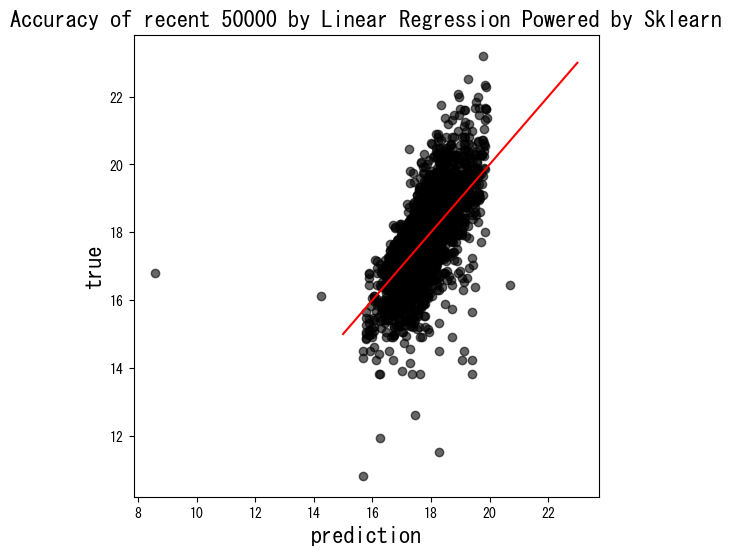

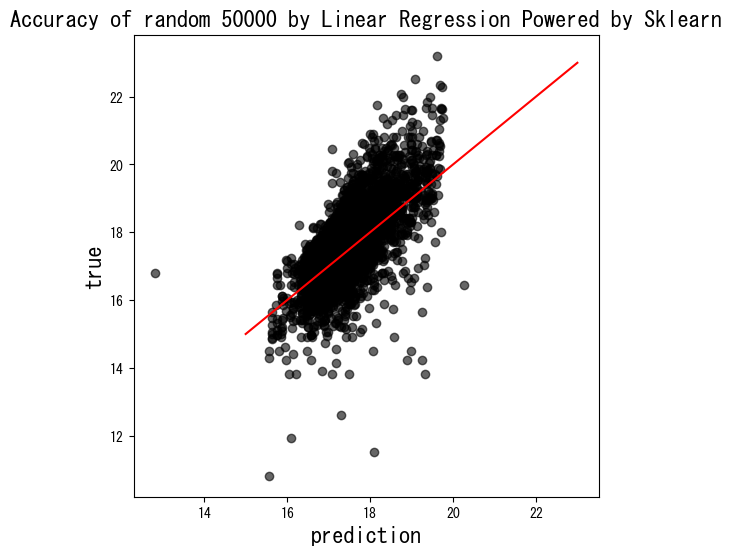

In [10]:
show_predict_accuracy_figure(lr_y_test_recent, 
                             lr_y_test_predict_recent, 
                             "Accuracy of recent 50000 by Linear Regression Powered by Sklearn")
show_predict_accuracy_figure(lr_y_test_random, 
                             lr_y_test_predict_random, 
                             "Accuracy of random 50000 by Linear Regression Powered by Sklearn")

<font color = blue size=5> Define Lasso Linear Regression Function</font>

In [11]:
def lasso_linear_regression(x_train, x_test, y_train, y_test, df):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(x_train)
    X_test_scaled = scaler.transform(x_test)
    alpha = 0.01
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train_scaled, y_train)
    y_test_predict = lasso_model.predict(X_test_scaled)
    print("\nTraining result powered by Lasso Regression Model")
    show_Rsquare_and_mse(y_test, y_test_predict)
    coefficients = lasso_model.coef_
    for feature, coef in zip(df.columns, coefficients):
        print(f"{feature}: {coef}")
    return y_test, y_test_predict  

In [12]:
print("\n\n########## Lasso Linear regression result on recent 50000 data powered by Sklearn ##########")
las_y_test_recent, las_y_test_predict_recent = lasso_linear_regression(recent50000_feature, 
                                                                     test_feature,
                                                                     recent50000_label, 
                                                                     test_label,
                                                                     recent50000_feature_df)
print("\n\n########## Lasso Linear regression result on random 50000 data powered by Sklearn ##########")
las_y_test_random, las_y_test_predict_random = lasso_linear_regression(random50000_feature, 
                                                                        test_feature,
                                                                        random50000_label, 
                                                                        test_label,
                                                                        random50000_feature_df)



########## Lasso Linear regression result on recent 50000 data powered by Sklearn ##########

Training result powered by Lasso Regression Model
R-squared: 0.3083153099156911
Mean Squared Error: 0.6193547615478922
area: 0.35994179982690644
longitude: 0.2526910318828098
latitude: 0.04689790517341657
種類_中古マンション等: -0.1511908170316618
種類_宅地(土地): 0.0
種類_宅地(土地と建物): 0.11376278479012239
種類_林地: -0.2983943790334744
種類_農地: -0.10471444095515353
取引の事情等_その他事情有り: -0.0
取引の事情等_瑕疵有りの可能性: -0.0
取引の事情等_私道を含む取引: -0.02229351796348588
取引の事情等_調停・競売等: -0.019718728012611052
取引の事情等_調停・競売等、私道を含む取引: -0.0019237697180015658
取引の事情等_関係者間取引: -0.0057876553407495025
取引の事情等_関係者間取引、私道を含む取引: -0.001243623033162912
取引の事情等_隣地の購入: -0.0
取引の事情等_隣地の購入、私道を含む取引: -0.0


########## Lasso Linear regression result on random 50000 data powered by Sklearn ##########

Training result powered by Lasso Regression Model
R-squared: 0.25294559833201735
Mean Squared Error: 0.668934425528458
area: 0.39349361920221543
longitude: 0.2160550400090530

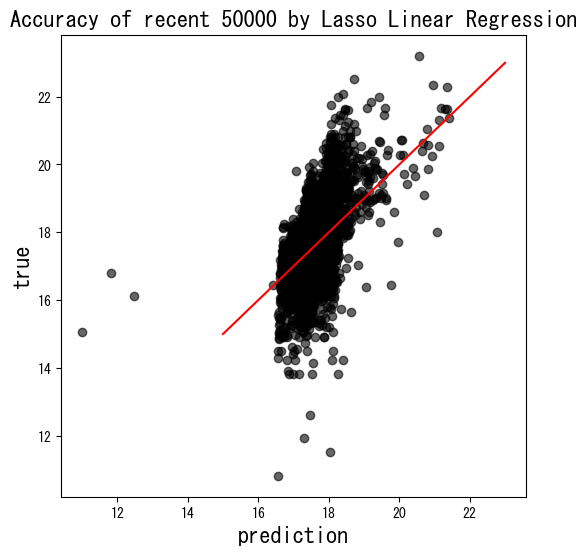

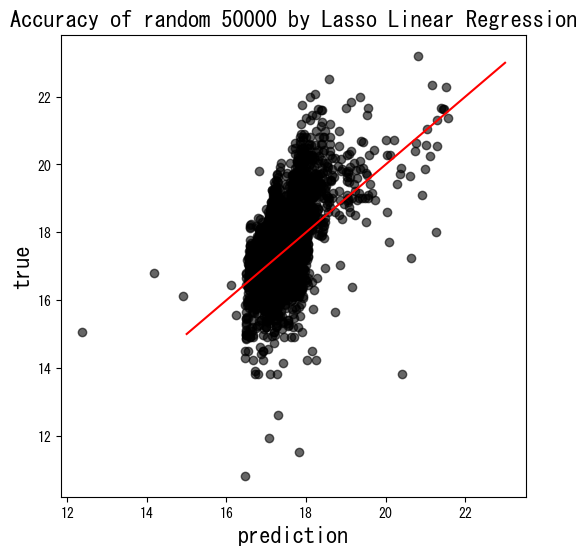

In [13]:
show_predict_accuracy_figure(las_y_test_recent, 
                             las_y_test_predict_recent, 
                             "Accuracy of recent 50000 by Lasso Linear Regression")
show_predict_accuracy_figure(las_y_test_random, 
                             las_y_test_predict_random, 
                             "Accuracy of random 50000 by Lasso Linear Regression")

<font color = blue size=5> Define OLS Linear Regression Function</font>

In [14]:
## Linear Regression powered by statisics model
def stats_linear_regression(x_train, x_test, y_train, y_test):
    # stats model
    reg_linear = sm.OLS(y_train, data_normalize(x_train))
    result = reg_linear.fit()
    # prediction
    y_test_predict = result.predict(data_normalize(x_test))
    print("\nTraining result powered by Stats Model")
    # print(mean_squared_error(y_test_predict, y_test))
    print(result.summary())
    return y_test, y_test_predict

In [15]:
print("\n\n########## OLS result on recent 50000 data powered by Statismodel ##########")
OLS_y_test_random, OLS_y_test_predict_random = stats_linear_regression(recent50000_feature, 
                                                                        test_feature,
                                                                        recent50000_label, 
                                                                        test_label)

print("\n\n########## OLS result on random 50000 data powered by Statismodel ##########")
OLS_y_test_random, OLS_y_test_predict_random = stats_linear_regression(random50000_feature, 
                                                                        test_feature,
                                                                        random50000_label, 
                                                                        test_label)



########## OLS result on recent 50000 data powered by Statismodel ##########

Training result powered by Stats Model
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     2236.
Date:                Sat, 13 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:58:23   Log-Likelihood:                -53290.
No. Observations:               50000   AIC:                         1.066e+05
Df Residuals:                   49983   BIC:                         1.068e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------

<font color = blue size=5> Define Random Forest Function Function</font>

In [16]:
def show_importance_map(importance, df, title):
    plt.figure(figsize=(6,6))
    importances = pd.Series(importance, index=df.columns)
    importances = importances.sort_values()
    importances[-15:].plot(kind="barh")
    plt.title(title)

def ranfom_forest(x_train, x_test, y_train, y_test, df, importance_map_title):
    # Hyper Parameter Learning
    hyper_para_learn = 0
    reg_rf = RandomForestRegressor()
#     x_train = data_normalize(x_train)
#     x_test = data_normalize(x_test)

    if hyper_para_learn == 1:
        reg_rf_cv = GridSearchCV(reg_rf, {
            'max_depth': [2, 6, 10],
            'n_estimators': [100, 1000, 5000],
            'max_features': ['log2'],
            'n_jobs': [24]
        }, verbose=1)
        reg_rf_cv.fit(x_train, y_train)
        parm_dict = reg_rf_cv.best_params_
        print(parm_dict)
        print(reg_rf_cv.best_score_)
    else:
        parm_dict = {}       
        parm_dict["max_depth"] = 10
        parm_dict["max_features"] = 'log2'
        parm_dict["n_estimators"] = 5000
        parm_dict["n_jobs"] = 24

    reg_rf = RandomForestRegressor(
        max_depth = parm_dict["max_depth"], 
        max_features = parm_dict["max_features"], 
        n_estimators = parm_dict["n_estimators"], 
        n_jobs = parm_dict["n_jobs"])
    reg_rf.fit(x_train, y_train)
    y_test_predict = reg_rf.predict(x_test)
    print("\nTraining result powered by Random Forest")
    show_Rsquare_and_mse(y_test, y_test_predict)
    print("Model Feature Importance:")
    importances = reg_rf.feature_importances_
    for feature, importance in zip(df.columns, importances):
        print(f"{feature}: {importance}")
    show_importance_map(reg_rf.feature_importances_, df, importance_map_title)
    return y_test, y_test_predict



########## Random Forest regression result on recent 50000 data ##########

Training result powered by Random Forest
R-squared: 0.6566789683339531
Mean Squared Error: 0.30741972281616153
Model Feature Importance:
area: 0.4988360019352471
longitude: 0.21998246778342084
latitude: 0.10617836668514416
種類_中古マンション等: 0.06189810572837639
種類_宅地(土地): 0.01401796539807084
種類_宅地(土地と建物): 0.04708697237036509
種類_林地: 0.03907493543263071
種類_農地: 0.0059909036601612725
取引の事情等_その他事情有り: 4.401778199484921e-05
取引の事情等_瑕疵有りの可能性: 0.00011097668694262591
取引の事情等_私道を含む取引: 0.0030877185985753413
取引の事情等_調停・競売等: 0.0013792693822851881
取引の事情等_調停・競売等、私道を含む取引: 0.00022190165279331088
取引の事情等_関係者間取引: 0.0011558940329873142
取引の事情等_関係者間取引、私道を含む取引: 0.00017103114669955095
取引の事情等_隣地の購入: 0.0005361012239727209
取引の事情等_隣地の購入、私道を含む取引: 0.0002273705003326173


########## Random Forest regression result on random 50000 data ##########

Training result powered by Random Forest
R-squared: 0.5696771245038885
Mean Squared Error: 0.385323725914

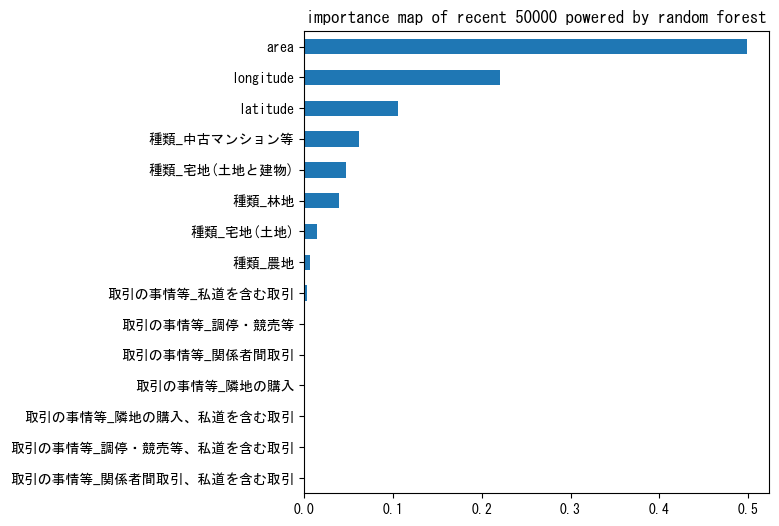

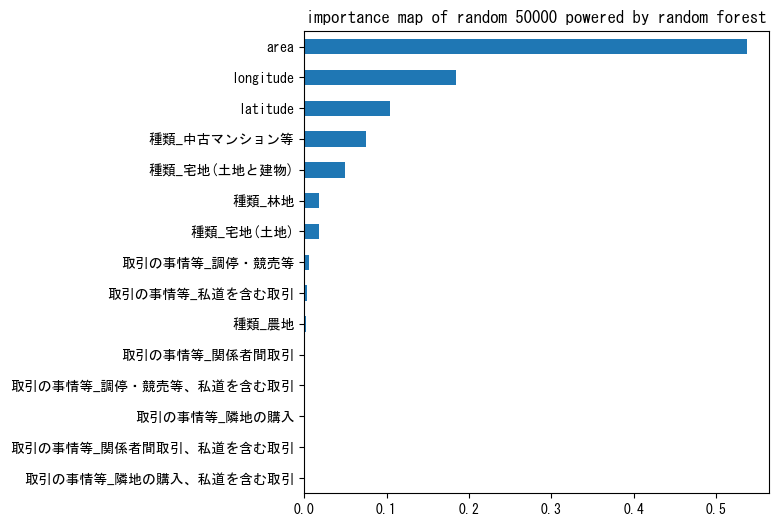

In [17]:
print("\n\n########## Random Forest regression result on recent 50000 data ##########")
rf_y_test_recent, rf_y_test_predict_recent = ranfom_forest(recent50000_feature, 
                                                           test_feature, 
                                                           recent50000_label, 
                                                           test_label, 
                                                           recent50000_feature_df, 
                                                           "importance map of recent 50000 powered by random forest")

print("\n\n########## Random Forest regression result on random 50000 data ##########")
rf_y_test_random, rf_y_test_predict_random = ranfom_forest(random50000_feature, 
                                                           test_feature, 
                                                           random50000_label, 
                                                           test_label, 
                                                           random50000_feature_df, 
                                                           "importance map of random 50000 powered by random forest")

<font color = blue size=5> Define XGB Function Function</font>

In [18]:
def gradient_boosting(x_train, x_test, y_train, y_test, df, importance_map_title):
    # Hyper Parameter Learning
    learning_rate = 0.1
    hyper_para_learn = 0
    reg_rf = RandomForestRegressor()
    if hyper_para_learn == 1:
        reg_rf_cv = GridSearchCV(reg_rf, {
            'max_depth': [2, 6, 10],
            'n_estimators': [100, 1000, 5000],
            'n_jobs': [24]
        }, verbose=1)
        reg_rf_cv.fit(x_train, y_train)
        parm_dict = reg_rf_cv.best_params_
        print(parm_dict)
        print(reg_rf_cv.best_score_)
    else:
        parm_dict = {}       
        parm_dict["max_depth"] = 10
        parm_dict["n_estimators"] = 5000
        parm_dict["n_jobs"] = 24

    reg_xgb = xgb.XGBRegressor(learning_rate = learning_rate,
                               n_estimators = parm_dict["n_estimators"],
                               max_depth = parm_dict["max_depth"],
                               n_jobs = parm_dict["n_jobs"])
    reg_xgb.fit(x_train, y_train)
    y_test_predict = reg_xgb.predict(x_test)
    print("\nTraining result powered by Grident Boosting")
    show_Rsquare_and_mse(y_test, y_test_predict)
    print("Model Feature Importance:")
    importances = reg_xgb.feature_importances_
    for feature, importance in zip(df.columns, importances):
        print(f"{feature}: {importance}")
    show_importance_map(reg_xgb.feature_importances_, df, importance_map_title)
    return y_test, y_test_predict



########## Grident Boosting regression result on recent 50000 data ##########

Training result powered by Grident Boosting
R-squared: 0.6869800840964437
Mean Squared Error: 0.2802872149021509
Model Feature Importance:
area: 0.04973591864109039
longitude: 0.035686880350112915
latitude: 0.03204427286982536
種類_中古マンション等: 0.008472505025565624
種類_宅地(土地): 0.00765584921464324
種類_宅地(土地と建物): 0.015589170157909393
種類_林地: 0.5688657164573669
種類_農地: 0.22708047926425934
取引の事情等_その他事情有り: 0.0033060505520552397
取引の事情等_瑕疵有りの可能性: 0.002921097446233034
取引の事情等_私道を含む取引: 0.005610044114291668
取引の事情等_調停・競売等: 0.006256985478103161
取引の事情等_調停・競売等、私道を含む取引: 0.005677361041307449
取引の事情等_関係者間取引: 0.013353920541703701
取引の事情等_関係者間取引、私道を含む取引: 0.006233620457351208
取引の事情等_隣地の購入: 0.005283720791339874
取引の事情等_隣地の購入、私道を含む取引: 0.00622638501226902


########## Grident Boosting regression result on recent 50000 data ##########

Training result powered by Grident Boosting
R-squared: 0.606243817120161
Mean Squared Error: 0.3525808366899

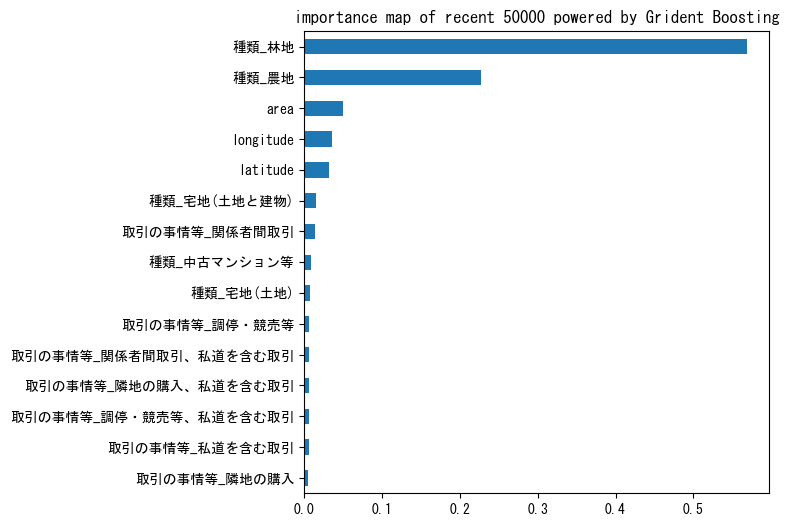

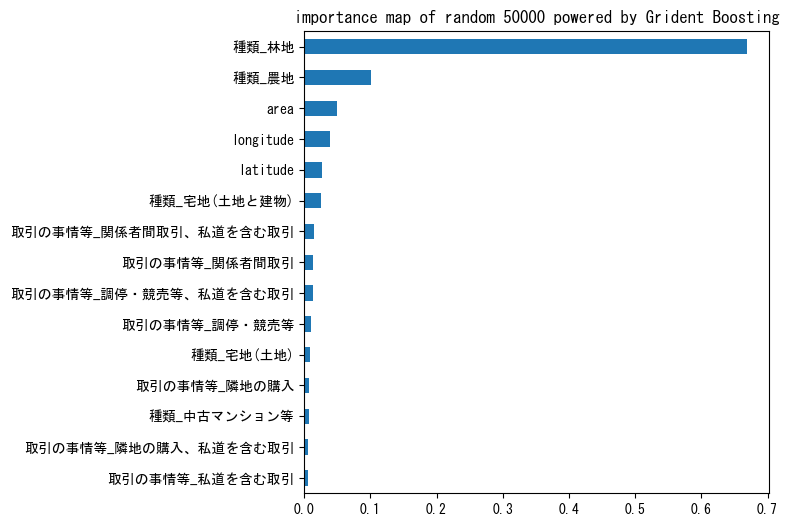

In [19]:
print("\n\n########## Grident Boosting regression result on recent 50000 data ##########")
gb_y_test_recent, gb_y_test__predict_recent = gradient_boosting(recent50000_feature, 
                                                                test_feature, 
                                                                recent50000_label, 
                                                                test_label, 
                                                                recent50000_feature_df, 
                                                                "importance map of recent 50000 powered by Grident Boosting")
print("\n\n########## Grident Boosting regression result on recent 50000 data ##########")
gb_y_test_random, gb_y_test__predict_random = gradient_boosting(random50000_feature, 
                                                                test_feature, 
                                                                random50000_label, 
                                                                test_label, 
                                                                random50000_feature_df, 
                                                                "importance map of random 50000 powered by Grident Boosting")